Будем работать с Book-Crossing Dataset: http://www2.informatik.uni-freiburg.de/~cziegler/BX/
Пользователи давали оценку прочитанным книгах в баллах от 0 до 10. 
На основе этих данных (плюс данные о пользователях и данные о книгах) постройте рекомендательную систему.

### Анализ и обработка данных

Посмотрите, что находится в файлах BX-Users, BX-Books и BX-Book-ratings. Затем сделайте обработку файла с рейтингами, как мы делали в ноутбуке recsys.

In [47]:
import pandas as pd
import numpy as np
import math

In [15]:
users = pd.read_csv("BX-Users.csv", encoding='cp1251', error_bad_lines=False, delimiter=';')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [16]:
books = pd.read_csv("BX-Books.csv", encoding='cp1251', error_bad_lines=False, delimiter=';')
books.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\elena\Anaconda3\lib\site-packages\IPython\core\interactiveshell.p

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [35]:
interactions_df = pd.read_csv("BX-Book-Ratings.csv", encoding='cp1251', error_bad_lines=False, delimiter=';')
interactions_df['personId'] = interactions_df['User-ID']
interactions_df['contentId'] = interactions_df['ISBN']
interactions_df['eventStrength'] = interactions_df['Book-Rating']
del interactions_df['User-ID'], interactions_df['ISBN'], interactions_df['Book-Rating']
interactions_df.head()

,personId,contentId,eventStrength
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [36]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)

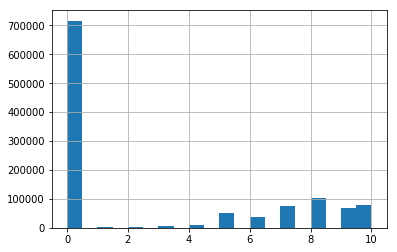

In [38]:
interactions_df.eventStrength.hist(bins=20)

In [39]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 105283
# users with at least 5 interactions: 22816


In [42]:
interactions_from_selected_users_df = \
    interactions_df.loc[
        np.in1d(
            interactions_df.personId,
            users_with_enough_interactions_df)]

In [44]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (1149780, 3)
# interactions after: (1028948, 3)


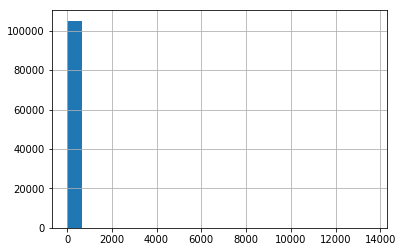

In [45]:
users_interactions_count_df.hist(bins=20)

In [49]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(10)

,personId,contentId,eventStrength
0,100004,0061015725,0.000000
1,100004,0345339703,3.459432
2,100004,0345339711,0.000000
3,100004,0345339738,0.000000
4,100004,0345380371,0.000000
5,100004,0399146652,3.169925
6,100004,0425083837,3.459432
7,100004,0439064872,3.459432
8,100004,0440414806,0.000000
9,100004,0446604275,0.000000


In [72]:
from sklearn.model_selection import train_test_split

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, test_size=0.95, random_state=111)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 51447
# interactions on Test set: 977501


In [73]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

KeyboardInterrupt: 

### Модель по популярности

Постройте модель, в которой каждому пользователю предлагается 10 самых популярных книг, кроме тех, которые он уже читал. Посмотрите на метрику качества.

In [60]:
interactions_train_df.head()

,personId,contentId,eventStrength
273992,167223,0804119708,0.0
39189,110483,0812514319,0.0
727446,275970,0201354934,0.0
963584,84024,0553250426,0.0
500281,223714,0399149155,0.0


In [62]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [63]:
popular_content

array(['0316666343', '0385504209', '0971880107', ..., '0451408349',
       '0451408411', 'cn113107'], dtype=object)

In [74]:
len(popular_content)

65135

In [64]:
from tqdm import tqdm

tqdm.pandas()

top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .progress_apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)


  3%|██▎                                                                           | 478/16252 [00:13<07:26, 35.36it/s]


  6%|████▌                                                                         | 942/16252 [00:29<18:57, 13.46it/s]


  9%|██████▊                                                                      | 1432/16252 [00:45<04:58, 49.62it/s]


 11%|████████▊                                                                    | 1868/16252 [01:01<12:06, 19.81it/s]


 14%|███████████                                                                  | 2327/16252 [01:15<05:06, 45.44it/s]


 17%|█████████████▏                                                               | 2787/16252 [01:26<06:19, 35.48it/s]


 20%|███████████████▌                                                             | 3275/16252 [01:40<06:24, 33.72it/s]


 23%|█████████████████▊                                                           | 3758/16252 [01:55<03:59, 52.21it/s]


 26%|████████████████████                                                         | 4237/16252 [02:08<05:35, 35.82it/s]


 29%|██████████████████████▎                                                      | 4701/16252 [02:24<05:12, 36.94it/s]


 32%|████████████████████████▌                                                    | 5182/16252 [02:38<05:28, 33.69it/s]


 35%|██████████████████████████▊                                                  | 5653/16252 [02:52<08:25, 20.97it/s]


 38%|█████████████████████████████▏                                               | 6171/16252 [03:06<08:22, 20.08it/s]


 41%|███████████████████████████████▍                                             | 6634/16252 [03:22<11:44, 13.66it/s]


 44%|█████████████████████████████████▋                                           | 7119/16252 [03:35<04:42, 32.37it/s]


 47%|████████████████████████████████████▏                                        | 7633/16252 [03:49<02:12, 65.17it/s]


 50%|██████████████████████████████████████▎                                      | 8081/16252 [04:03<08:36, 15.81it/s]


 53%|████████████████████████████████████████▊                                    | 8601/16252 [04:20<04:35, 27.79it/s]


 56%|██████████████████████████████████████████▉                                  | 9054/16252 [04:35<03:47, 31.63it/s]


 59%|█████████████████████████████████████████████▏                               | 9531/16252 [04:48<02:47, 40.10it/s]


 61%|███████████████████████████████████████████████▎                             | 9993/16252 [05:02<02:15, 46.21it/s]


 65%|█████████████████████████████████████████████████                           | 10504/16252 [05:14<02:17, 41.68it/s]


 68%|███████████████████████████████████████████████████▎                        | 10986/16252 [05:29<02:20, 37.59it/s]


 71%|█████████████████████████████████████████████████████▌                      | 11465/16252 [05:42<08:54,  8.96it/s]


 73%|███████████████████████████████████████████████████████▊                    | 11925/16252 [05:55<02:05, 34.54it/s]


 76%|██████████████████████████████████████████████████████████                  | 12418/16252 [06:11<01:49, 34.95it/s]


 80%|████████████████████████████████████████████████████████████▍               | 12929/16252 [06:22<01:34, 35.05it/s]


 82%|██████████████████████████████████████████████████████████████▋             | 13401/16252 [06:36<04:22, 10.85it/s]


 86%|█████████████████████████████████████████████████████████████████           | 13900/16252 [06:49<00:56, 41.62it/s]


 88%|███████████████████████████████████████████████████████████████████▎        | 14382/16252 [07:01<00:59, 31.27it/s]


 92%|█████████████████████████████████████████████████████████████████████▋      | 14890/16252 [07:16<01:11, 18.96it/s]


 94%|███████████████████████████████████████████████████████████████████████▊    | 15356/16252 [07:27<00:34, 26.06it/s]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 15799/16252 [07:39<00:13, 34.23it/s]


100%|███████████████████████████████████████████████████████████████████████████▊| 16209/16252 [07:55<00:01, 31.69it/s]


100%|████████████████████████████████████████████████████████████████████████████| 16252/16252 [07:55<00:00, 34.15it/s]

In [65]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [66]:
calc_precision('prediction_popular')

0.03514078792161556

### Коллаборативная фильтрация

Так как датасет очень большой (и пользователей, и книг много), оставим только информацию о взаимодействии пользователей с 1000й самых популярных книг и будем делать предсказания только внутри этих 1000 книг.

In [79]:
interactions_small_df = interactions_full_df[interactions_full_df.contentId.isin(popular_content[:1000])]

In [81]:
interactions_small_df.shape, interactions_full_df.shape

((118684, 3), (1028948, 3))

In [82]:
interactions_train_df, interactions_test_df = train_test_split(interactions_small_df, test_size=0.9, random_state=111)

In [83]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
100004,[0345339703],"[0061015725, 0345339711, 0440414806, 034533973..."


In [84]:
interactions_train_df.shape

(11868, 3)

In [85]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [86]:
ratings.head()

contentId,0020442602,002542730X,006000438X,0060008032,006001203X,006016848X,0060173289,0060175400,0060199652,0060256656,...,1904492355,2253010219,2253057843,2253150711,2290315095,3150000017,3453007867,3492045170,3499121581,8423310353
personId,,,,,,,,,,,,,,,,,,,,,
100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
ratings_m = ratings.as_matrix()

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [88]:
from tqdm import tqdm_notebook

similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # normalization
        # ...
        ratings_v = ratings_v / np.linalg.norm(ratings_v)
        ratings_u = ratings_u / np.linalg.norm(ratings_u)
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        
#         similarity_users[i,j] = # your code
#         similarity_users[j,i] = # your code
        similarity_users[i,j] = np.corrcoef(ratings_u, ratings_v)[0][1]
        similarity_users[j,i] = similarity_users[i,j]

In [90]:
# your code
alpha = 0
Similarities = {}

for i in tqdm_notebook(range(len(similarity_users))):
    Similarities[ratings.index[i]] = []
    for j in range(len(similarity_users)):
        if similarity_users[i,j] > alpha:
            Similarities[ratings.index[i]].append(ratings.index[j])
    Similarities[ratings.index[i]] = list(set(Similarities[ratings.index[i]]))

#interactions['prediction_user_based'] = # your code

In [91]:
from tqdm import tqdm

Viewed = {}

for user, row in tqdm_notebook(ratings.iterrows()): 
    Viewed[user] = interactions.loc[user]['true_train']

In [92]:
Viewed[ratings.index[0]]

['0345339703']

In [93]:
# ratings.index - users
# ratings.columns - articles

def get_popular(user, top_k=10):
    sim_users = ratings[ratings.index.isin(Similarities[user])] #оставляем в таблице только похожих
    sim_users = sim_users.drop(Viewed[user], axis=1) #убираем статьи, которые user уже смотрел
    return sim_users.astype(bool).sum(axis=0).sort_values(ascending=False).iloc[:top_k].index
    #считаем количество взаимодействий (=ненулевых элементов)

In [94]:
interactions['prediction_user_based'] = ratings.index.map(get_popular)

In [95]:
calc_precision('prediction_user_based')

0.015624907595765073

### Модель со скрытыми переменными

In [99]:
from scipy.linalg import svd

In [100]:
U, sigma, V = svd(ratings)

In [101]:
ratings.shape, U.shape, sigma.shape, V.shape

((5395, 978), (5395, 5395), (978,), (978, 978))

In [103]:
Sigma = np.zeros((5395, 978))
Sigma[:978, :978] = np.diag(sigma)

In [104]:
new_ratings = U.dot(Sigma).dot(V)

In [105]:
sum(sum((new_ratings - ratings.values) ** 2))

4.137223067571087e-25

In [106]:
sigma[100:] = 0
Sigma = np.zeros((5395, 978))
Sigma[:978, :978] = np.diag(sigma)

In [107]:
new_ratings = U.dot(Sigma).dot(V)

In [108]:
sum(sum((new_ratings - ratings.values) ** 2))

29053.102751888808

In [109]:
new_ratings = pd.DataFrame(
    new_ratings, index=ratings.index, columns=ratings.columns)

In [110]:
predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

In [111]:
interactions['prediction_svd'] = predictions

In [112]:
calc_precision('prediction_svd')

0.029707816705063998

### Контентная модель

Напишите контентную модель для рекомендаций. Используйте признаки из таблиц о пользователях и о книгах.

In [ ]:
#your code here